In [1]:
from pathlib import Path
import argparse
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as T
from utils.io import load, dump, cmd_args_to_dict
from utils.load_config import instantiate
from utils.io import load
import subprocess

from data.CocoStuffDataset import CocoStuffDataset, cocostuff_classes
from src.zestguide_stbl14 import GradientGuidedSynthesis2
import zestguide_utils



model =  GradientGuidedSynthesis2()

/private/home/marlenec/.conda/envs/zestguide/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
text_encoder/model.safetensors not found
Loading pipeline components...:  57%|█████████████████████████████████████████████████████████████████████▋                                                    | 4/7 [00:01<00:01,  2.93it/s]/private/home/marlenec/.conda/envs/zestguide/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Loading pipeline components...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.83it/s]


In [2]:
import zestguide_utils
from functools import partial
model.num_inference_steps= 50
model.guidance_scale= 7.5
model.tau= 0.5
model.lr= 0.3
model.temp= 1
model.loss_scaler= 10
model.loss_ls= 0.1
model.lr_schedule= True
model.use_32_blocks= True
model.ddim_eta= 0.5
model.negative_mode= 'concat'
model.grad_norm= 'l0'
model.clip_init= False
model.average_maps_layerwise= True

model.loss = partial(zestguide_utils.bce_loss2, 
                            scaler=model.loss_scaler,
                           ls=model.loss_ls)

In [3]:
# seed = 1
seed = 17


## BEAR MASK

In [8]:
dataset = CocoStuffDataset(data_dir='/datasets01/COCO/022719/', lab_dir = '/datasets01/COCO-Stuff/072318', caption_dir='/checkpoint/marlenec/cocostuff/annotations', load_size = 512)


eval_setting='eval_few'
list_classes = cocostuff_classes 

chosen_idx = 1
batch = dataset[chosen_idx]
gt_im = batch['image']

# generate spatial mask stuff
spa_mask = batch['label']
idx_lbl, count_lbl = torch.unique(spa_mask, return_counts=True)


idx_lbl = idx_lbl[count_lbl > 5 / 100 * spa_mask.size(-2) * spa_mask.size(1)]
idx_lbl = idx_lbl[idx_lbl != 0]



if eval_setting=='eval_few' and False:
    # select between 1 and 3 segments in the mask
    min_segm = 1
    max_segm = 3
    if min_segm == idx_lbl.size(0):
        K = min_segm
    else:
        K = torch.randint(min_segm, min(max_segm+1, idx_lbl.size(0)+1), (spa_mask.size(0),))
    K=3
    rnd_select_idx = torch.randperm(idx_lbl.size(0))[:K]
    selected_cls = idx_lbl[rnd_select_idx]
else:
    selected_cls = idx_lbl

# idx2words = {int(i.item()): list_classes[int(i.item())].replace('-stuff', '').replace('-', ' ').split(" ") for i in selected_cls}
idx2words = {int(i.item()): list_classes[int(i.item())].replace('-stuff', '').replace('-', ' ') for i in selected_cls}
selected_mask = torch.stack([i * (spa_mask == i).float() for i in idx2words.keys()]).sum(0)

caption = batch['annotation'][0]
       
local_prompt = [x for x in idx2words.values() if x not in caption]
prompt = caption + ' ' + ', '.join(local_prompt)

Size of datasets for images/ labels:  5000 5000


## CAT MASK

In [4]:
a = torch.load('../diffusion/stable-diffusion/assets/teaser_paper/im6.pt')
a['caption'] = 'A realistic photograph of a cat wearing a beautiful dress.'
a['idx2words'][1] = 'beautiful dress'
idx2words = a['idx2words']
selected_mask = a['mask']
prompt = a['caption']

print('idx2words: ', idx2words)
print('Prompt: ', prompt)

idx2words:  {1: 'beautiful dress', 2: 'cat'}
Prompt:  A realistic photograph of a cat wearing a beautiful dress.


## Visualization of masks

MASK for class:  beautiful dress


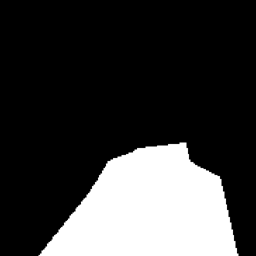

MASK for class:  cat


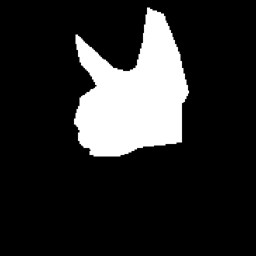

In [5]:
class_idx = list(idx2words.keys())
for c in class_idx:
    print('MASK for class: ', idx2words[c])
    display(T.ToPILImage()((selected_mask[0]==c).float()).resize((256,256)))

/private/home/marlenec/.conda/envs/zestguide/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:237: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
/private/home/marlenec/zestguide/src/zestguide_stbl14.py:271: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = pipe.unet.in_channels
51it [00:22,  2.29it/s]
/private/home/marlenec/.conda/envs/zestguide/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:430: FutureWarning: The decode_latents method is deprecat

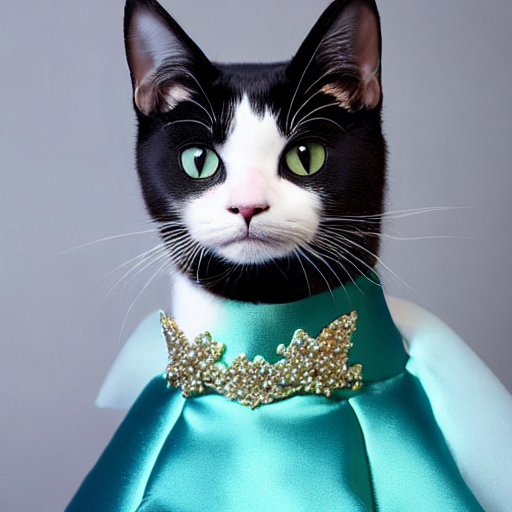

In [6]:
model.tau= 0.5
img = model.run(prompt, segmentation_mask=selected_mask,
                          idx2words=idx2words,
                         seed = seed)
display(img)

## How many diffusion steps with guidance are needed ?

51it [00:15,  3.24it/s]


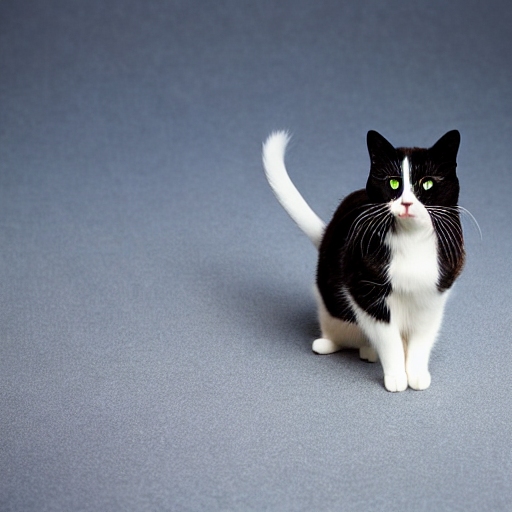

In [16]:
model.tau= 1. ## no guidance for almost all the timesteps
img = model.run(prompt, segmentation_mask=selected_mask,
                          idx2words=idx2words,
                         seed = seed)
img

51it [00:16,  3.11it/s]


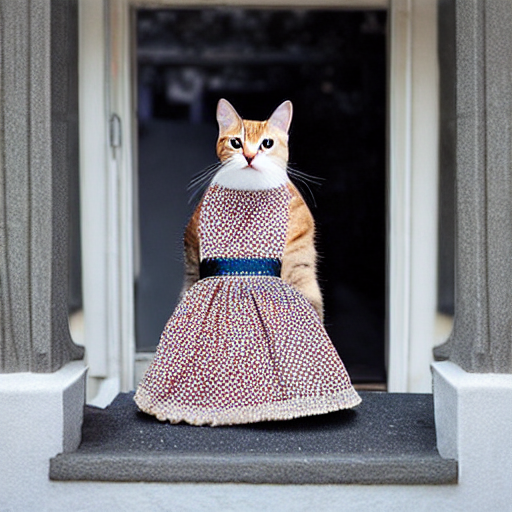

In [17]:
model.tau= 0.95 ## no guidance for almost all the timesteps
img = model.run(prompt, segmentation_mask=selected_mask,
                          idx2words=idx2words,
                         seed = seed)
img

51it [00:27,  1.84it/s]


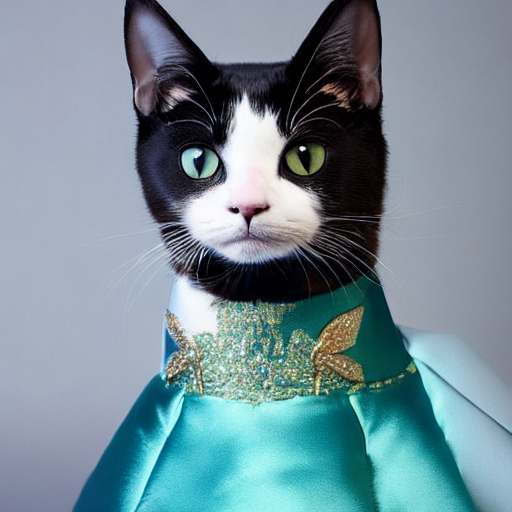

In [14]:
model.tau= 0.1 ## no guidance for almost all the timesteps
img = model.run(prompt, segmentation_mask=selected_mask,
                          idx2words=idx2words,
                         seed=seed)
img

## Impact of the learning rate

51it [00:22,  2.26it/s]


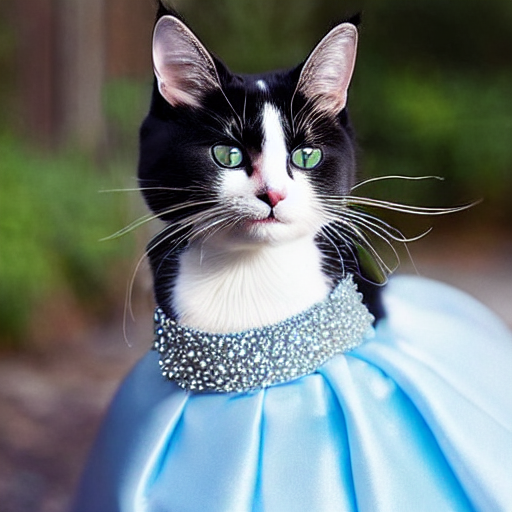

In [15]:
model.tau= 0.5
model.lr= 0.1
img = model.run(prompt, segmentation_mask=selected_mask,
                          idx2words=idx2words,
                         seed=seed)
img

51it [00:22,  2.26it/s]


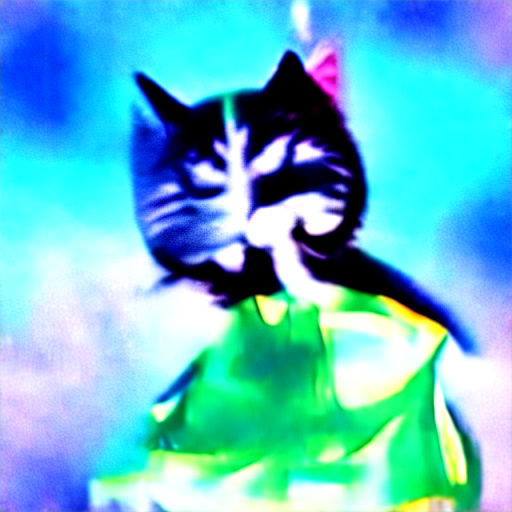

In [16]:
model.tau= 0.5
model.lr= 2

img = model.run(prompt, segmentation_mask=selected_mask,
                          idx2words=idx2words,
                         seed=seed)
img

51it [00:22,  2.29it/s]


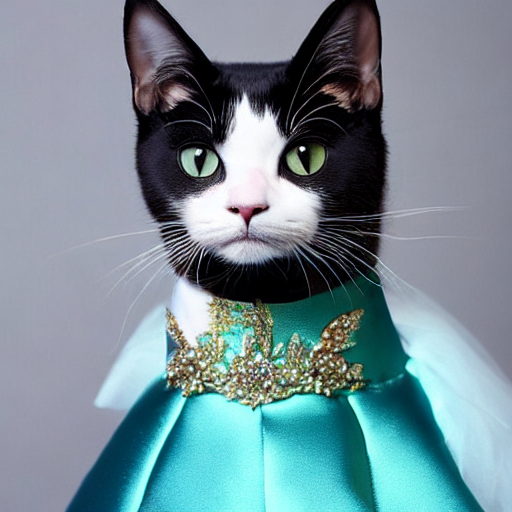

In [7]:
model.tau= 0.5
model.lr= 0.3

img = model.run(prompt, segmentation_mask=selected_mask,
                          idx2words=idx2words,
                         seed = seed)
img

## Which attention layers to use ?

51it [00:21,  2.33it/s]


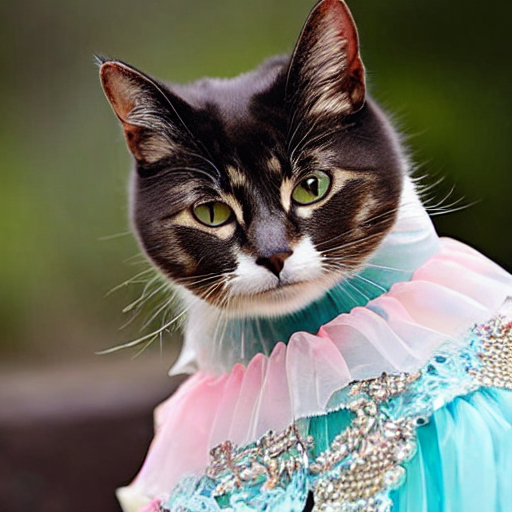

In [17]:
model.use_32_blocks= True
model.use_16_blocks= False
model.lr= 0.3
img = model.run(prompt, segmentation_mask=selected_mask,
                          idx2words=idx2words,
                          seed = seed)
img

51it [00:21,  2.41it/s]


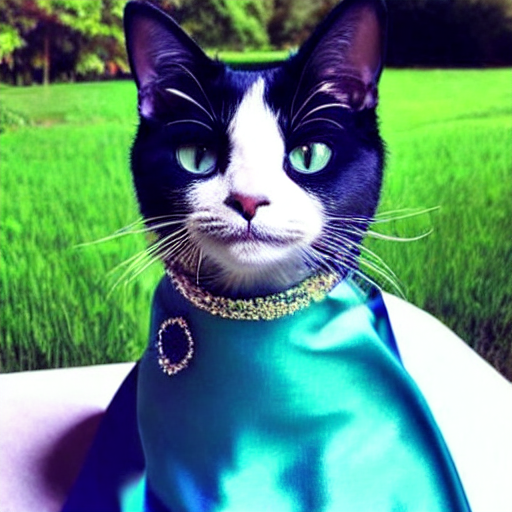

In [18]:
model.use_32_blocks= False
model.use_16_blocks= True

img = model.run(prompt, segmentation_mask=selected_mask,
                          idx2words=idx2words,
                          seed = seed)
img

0it [00:00, ?it/s]

applying loss


1it [00:00,  1.72it/s]

applying loss


2it [00:01,  1.74it/s]

applying loss


3it [00:01,  1.75it/s]

applying loss


4it [00:02,  1.75it/s]

applying loss


5it [00:02,  1.75it/s]

applying loss


6it [00:03,  1.74it/s]

applying loss


7it [00:04,  1.75it/s]

applying loss


8it [00:04,  1.74it/s]

applying loss


9it [00:05,  1.75it/s]

applying loss


10it [00:05,  1.75it/s]

applying loss


11it [00:06,  1.76it/s]

applying loss


12it [00:06,  1.76it/s]

applying loss


13it [00:07,  1.76it/s]

applying loss


14it [00:07,  1.76it/s]

applying loss


15it [00:08,  1.75it/s]

applying loss


16it [00:09,  1.76it/s]

applying loss


17it [00:09,  1.76it/s]

applying loss


18it [00:10,  1.75it/s]

applying loss


19it [00:10,  1.75it/s]

applying loss


20it [00:11,  1.75it/s]

applying loss


21it [00:11,  1.76it/s]

applying loss


22it [00:12,  1.75it/s]

applying loss


23it [00:13,  1.75it/s]

applying loss


24it [00:13,  1.74it/s]

applying loss


25it [00:14,  1.74it/s]

applying loss


51it [00:22,  2.27it/s]


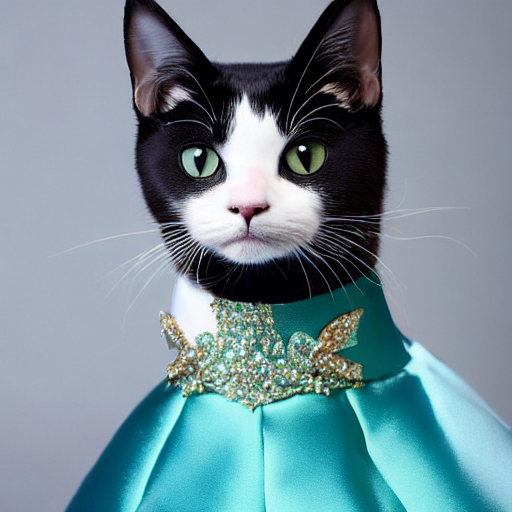

In [28]:
model.use_32_blocks= True
model.use_16_blocks= True

img = model.run(prompt, segmentation_mask=selected_mask,
                          idx2words=idx2words,
                         seed = seed)
img

## Impact of the seed

51it [00:22,  2.27it/s]


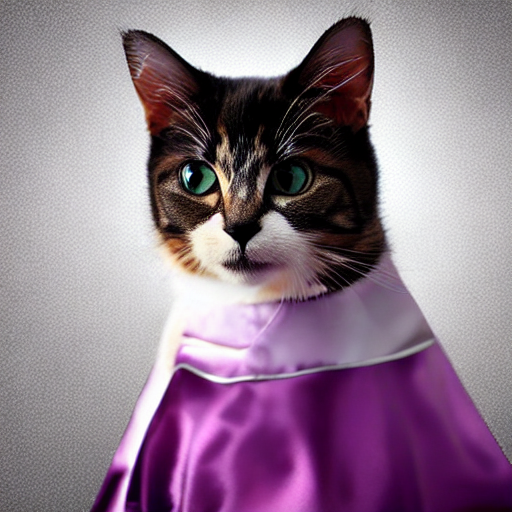

In [21]:
model.use_32_blocks= True
model.use_16_blocks= True
seed=41

img = model.run(prompt, segmentation_mask=selected_mask,
                          idx2words=idx2words,
                         seed = seed)
img

51it [00:22,  2.27it/s]


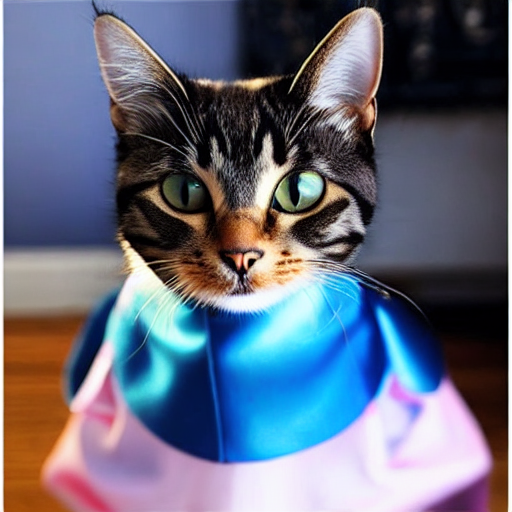

In [22]:
model.use_32_blocks= True
model.use_16_blocks= True
seed=1523

img = model.run(prompt, segmentation_mask=selected_mask,
                          idx2words=idx2words,
                         seed = seed)
img